# Import Libraries

Import useful libraries.

To use GPU, set `Edit / Notebook settings / Hardware accelerator` to **GPU**.

In [ ]:
!pip install image-dataset-loader

%tensorflow_version 2.x

import numpy as np
import tensorflow as tf
import keras

print("Tensorflow version %s" %tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.3.0
Found GPU at: /device:GPU:0


# Load the Dataset

In `/content/drive/MyDrive/ML2021/hw2/test` I have these folders: 
*   /accent_plate
*   /Buckets
*   /Jelly_Beans_bag
*   /juice_carton
*   /noodle_soup_cup
*   /plastic_food_container
*   /Sporks

In `/content/drive/MyDrive/ML2021/hw2/train` I have these folders: 
*   /accent_plate
*   /Buckets
*   /Jelly_Beans_bag
*   /juice_carton
*   /noodle_soup_cup
*   /plastic_food_container
*   /Sporks

We are interested in folders `test` and `train`.

Each one od these dirs contains the same folders, but with different elements in order to train the NN and to validate it.

Pictures are reduced at the same size 33*33 and padded where needed. (To avoid RAM overload)

Pictures with a width/height ratio where 0.5 < ratio < 1.5 are removed.

Here is the output of the script used for dividing the dataset:

```
Analyzed samples : 8032
Considered Samples with 0.5 < ratio < 1.5 : 7180
Average Width : 233.514069
Average Height : 222.001370
Ratio : 1.051859
Max Ratio : 4.0
Real New Size : 150 x 150
```
So we will have a total of 7180 samples.

For each directory in `test` folder we will have the 33% of the images.

The remaining pictures are given for training in the `train` folder.




Get Google Drive Access

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

test = 'test150'
train = 'train150'
img_width = 233.514069
img_height = 222.001370
desired_size = int(img_width)
print ('Pictures are sized %d x %d and padded where necessary.' %(desired_size, desired_size))

abspath = 'drive/MyDrive/ML2021/hw2'
print ('Absolute Path: ' + abspath)

test_path = abspath + '/' + test
print ('Test path: ' + test_path)

train_path = abspath + '/' + train 
print ('Train path: ' + train_path)

dirs = ['juice_carton', 'Buckets', 'Cherries', 'noodle_soup_cup', 'Sporks', 'accent_plate', 'Jelly_Beans_bag', 'plastic_food_container']

print ('Directory list in both test and train folders: ')
print (dirs)

#!unzip 'drive/MyDrive/ML2021/hw2/test150.zip' -d 'drive/MyDrive/ML2021/hw2'
#!unzip 'drive/MyDrive/ML2021/hw2/train150.zip' -d 'drive/MyDrive/ML2021/hw2'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Pictures are sized 233 x 233 and padded where necessary.
Absolute Path: drive/MyDrive/ML2021/hw2
Test path: drive/MyDrive/ML2021/hw2/test150
Train path: drive/MyDrive/ML2021/hw2/train150
Directory list in both test and train folders: 
['juice_carton', 'Buckets', 'Cherries', 'noodle_soup_cup', 'Sporks', 'accent_plate', 'Jelly_Beans_bag', 'plastic_food_container']


Loading the local dataset.

In [ ]:
from image_dataset_loader import load

def load_dataset() :
  (Xtrain, Ytrain), (Xtest, Ytest) = load(abspath, [train, test], seed=1)
  print ('Dataset loaded')

  Ytrain = np.array(tf.expand_dims(Ytrain, 1))
  Ytest = np.array(tf.expand_dims(Ytest, 1))

  print(Ytrain.shape)

  # Getting some info
  ninput = Xtrain.shape[0]
  imgsize = (Xtrain.shape[1], Xtrain.shape[2])
  input_shape = (Xtrain.shape[1], Xtrain.shape[2], Xtrain.shape[3])
  ntest = Xtest.shape[0]
  num_classes = np.max(np.unique(Ytrain)) + 1

  # Printing info
  print("Training input %s" %str(Xtrain.shape))
  print("Training output %s" %str(Ytrain.shape))
  print("Test input %s" %str(Xtest.shape))
  print("Test output %s" %str(Ytest.shape))
  print("Input shape: %s" %str(input_shape))
  print("Number of classes: %d" %num_classes)

  # normalize input to [0,1]
  Xtrain = Xtrain / 255.0
  Xtest = Xtest / 255.0

  # Transform output to one-out-of-n encoding
  Ytrain = keras.utils.to_categorical(Ytrain, num_classes)
  Ytest = keras.utils.to_categorical(Ytest, num_classes)
  
  return [Xtrain,Ytrain,Xtest,Ytest,input_shape,num_classes]

[Xtrain,Ytrain,Xtest,Ytest,input_shape,num_classes] = load_dataset()

Dataset loaded
(4786, 1)
Training input (4786, 150, 150, 3)
Training output (4786, 1)
Test input (2394, 150, 150, 3)
Test output (2394, 1)
Input shape: (150, 150, 3)
Number of classes: 8


# Show Random Image

3


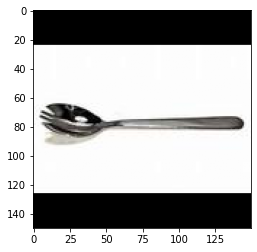

In [ ]:
import matplotlib.pyplot as plt
import random

i = random.randrange(0,Xtrain.shape[0])
image = Xtrain[i]
image = np.array(image, dtype='float')

label = Ytrain[i].argmax()  # categorical from one-hot-encoding
print(label)

plt.imshow(image, cmap='gray')
plt.show()

# CNN Ensemble Model

In [ ]:
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPool2D, Input
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers

# single model
def CNN(input_shape, num_classes, base_width=32, depth=5):
    
    inputs = Input(input_shape)
    
    image_size = input_shape[0]
    filters = base_width

    # feature extractor
    for i in range(depth):
        if i == 0:
            x = Conv2D(filters=filters,
                       kernel_size = 3,
                       activation="relu",
                       strides=1,
                       padding="same")(inputs)
        else:
            x = Conv2D(filters=filters,
                       kernel_size = 3,
                       activation="relu",
                       strides=1,
                       padding="same")(x)
        x = MaxPool2D()(x)
        filters *= 2
    
    x = Flatten()(x) 
    x = Dropout(0.8)(x)
    
    outputs = Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# ensemble model
def Ensemble(ens_dim, input_shape, num_classes, base_width=32, depth=5):
  inputs = Input(shape=input_shape)
  
  learners = [CNN(input_shape,
                  num_classes,
                  base_width,
                  depth) for _ in range(ens_dim)]
  
  outputs = [learners[i](inputs) for i in range(ens_dim)]
  
  ensemble_model = Model(inputs, outputs, name="ensemble_model")
  optimizer = 'adam'
  # an independent loss for each model
  losses = ["categorical_crossentropy" for _ in range(ens_dim)]
  ensemble_model.compile(loss=losses, optimizer=optimizer, metrics=['accuracy'])
  return ensemble_model


# create the ensemble model
ens_dim = 3
model = Ensemble(ens_dim, input_shape, num_classes)
model.summary()

# single model summary
model.get_layer(index=-1).summary()

Model: "ensemble_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
functional_31 (Functional)      (None, 8)            6401672     input_21[0][0]                   
__________________________________________________________________________________________________
functional_33 (Functional)      (None, 8)            6401672     input_21[0][0]                   
__________________________________________________________________________________________________
functional_35 (Functional)      (None, 8)            6401672     input_21[0][0]                   
Total params: 19,205,016
Trainable params: 19,205,016
Non-trainable params: 0
_______

# Train

In [ ]:
epochs = 30
history = model.fit(Xtrain, [Ytrain for _ in range(ens_dim)], batch_size=64, epochs=epochs, validation_data = (Xtest,[Ytest for _ in range(ens_dim)]))

Epoch 1/60
75/75 [==============================] - 32s 429ms/step - loss: 5.7263 - functional_31_loss: 1.9100 - functional_33_loss: 1.9068 - functional_35_loss: 1.9094 - functional_31_accuracy: 0.2534 - functional_33_accuracy: 0.2405 - functional_35_accuracy: 0.2503 - val_loss: 5.1274 - val_functional_31_loss: 1.7086 - val_functional_33_loss: 1.7366 - val_functional_35_loss: 1.6823 - val_functional_31_accuracy: 0.3705 - val_functional_33_accuracy: 0.3421 - val_functional_35_accuracy: 0.3688
Epoch 2/60
75/75 [==============================] - 31s 418ms/step - loss: 5.0480 - functional_31_loss: 1.6695 - functional_33_loss: 1.7028 - functional_35_loss: 1.6757 - functional_31_accuracy: 0.3740 - functional_33_accuracy: 0.3539 - functional_35_accuracy: 0.3807 - val_loss: 5.0265 - val_functional_31_loss: 1.6454 - val_functional_33_loss: 1.8100 - val_functional_35_loss: 1.5711 - val_functional_31_accuracy: 0.4160 - val_functional_33_accuracy: 0.3191 - val_functional_35_accuracy: 0.4231
Epoch 

All those performances are measured using the test set.
Now we have performances that are measured using the **cross validation** on the training set.




# Save the Model

In [ ]:
model.save('drive/MyDrive/ML2021/hw2/model_test8_1.h5')

# Compare Single Networks with Ensemble

In [ ]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# accuracy
ind_test_acc = []
ind_test_acc_profile = []
for key in history.history.keys():
  if ("val" in key) and ("accuracy" in key):
    ind_test_acc.append(history.history[key][-1])
    ind_test_acc_profile.append(history.history[key])
print("Single models test accuracy: ", ind_test_acc)

# ensemble test accuracy
preds = np.array(model.predict(Xtest))
# average over the ensemble (AT THE END OF THE LAST EPOCH)
preds_ens = np.mean(preds, axis=0)
ens_test_acc = accuracy_score(np.argmax(Ytest, axis=-1), np.argmax(preds_ens, axis=-1))
print("Ensemble test accuracy: ", ens_test_acc)

Single models test accuracy:  [0.7752715349197388, 0.7715120911598206, 0.774018406867981]
Ensemble test accuracy:  0.7961570593149541


`preds = np.array(model.predict(Xtest))`



Text(0.5, 0, 'epoch')

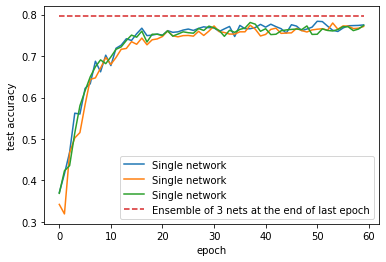

In [ ]:
plt.plot(np.transpose(ind_test_acc_profile), label="Single network")
plt.plot([ens_test_acc for _ in range(len(history.history[key]))], linestyle="--", label="Ensemble of {} nets at the end of last epoch".format(ens_dim))
plt.legend()
plt.ylabel('test accuracy')
plt.xlabel('epoch')